# Steady-State 1D CSR

This is a very example of how to calclate the 1D steady state CSR wake using an integrated Green function method. 

In [1]:
import numpy as np

from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

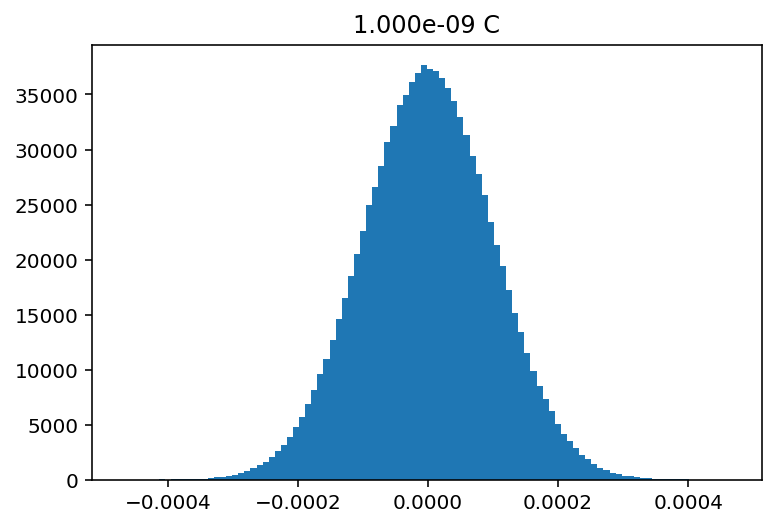

In [2]:
sigma_z = 100e-6
Qtot = 1e-9 # C
Np = 1000000
rho = 10

W0 = Qtot/e_charge * r_e * mec2 * rho**(-2/3) * sigma_z**(-4/3)

z = np.random.normal(0, sigma_z , size=Np)
weights = np.full(Np, Qtot/Np)

plt.hist(z, bins = Np//10000)
plt.title(f'{weights.sum():.3e} C')
plt.show()

In [3]:
# Rough scale of change in energy per unit distance in eV/m
W0

417165.2004071612

# Get density

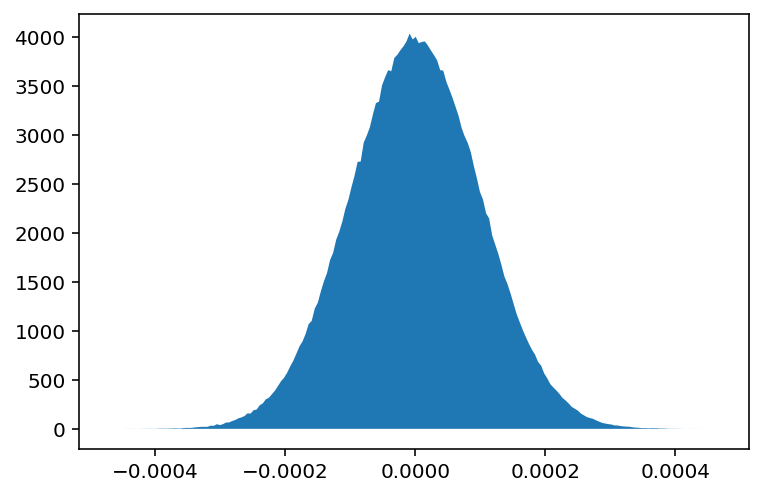

In [4]:
nz = 200
H, edges = np.histogram(z, weights=weights, bins=nz)
zmin, zmax = edges[0], edges[-1]
dz = (zmax-zmin)/(nz-1)

zvec = np.linspace(zmin, zmax, nz) # Sloppy with bin centers

density = H/dz/Qtot
plt.fill_between(zvec, 0, density)

In [5]:
# The total should sum to 1
np.sum(density)*dz

1.0000000000000064

# Density gradient

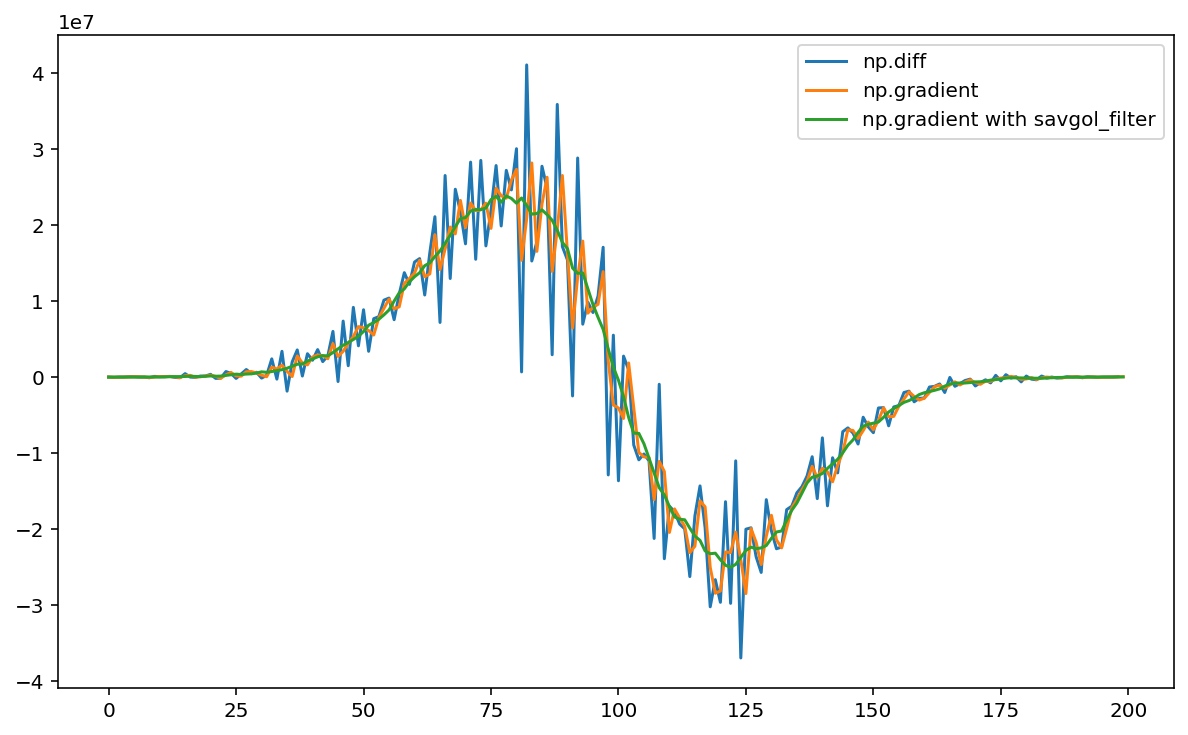

In [6]:
densityp = np.gradient(density)/dz

densityp_filtered = savgol_filter( densityp, 13, 2 )

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.diff(density)/dz, label='np.diff')
ax.plot(densityp, label='np.gradient')
ax.plot(densityp_filtered, label='np.gradient with savgol_filter')
#ax.plot(np.gradient(density, edge_order=2), label='np.gradient, edge_order=2', linestyle='--')
ax.legend()

# Green function

The steady-state CSR wake on a circle of radius $\rho$

 $W_\text{SS CSR} (z) = -\frac{2 N r_c m c^2}{3^{1/3} \rho^{2/3}} \int_0^\infty  \frac{1}{\Delta^{1/3}} \lambda'(z-\Delta) d\Delta$
 
This is Eq. 36 in: https://journals.aps.org/prab/abstract/10.1103/PhysRevSTAB.12.024401
 
Discretizing the charge density, the kernel can be integrated

$\int \frac{1}{\Delta^{1/3}} d\Delta = \frac{3}{2} \Delta^{2/3}$
 
and therefore the wake can be perfomed with a discrete convolution.


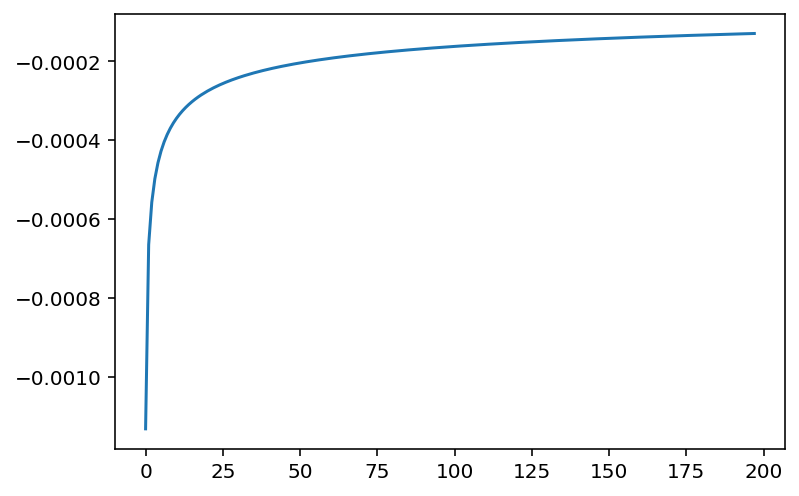

In [7]:
# Green function
# Create with the same spacing. 
zi = np.arange(0, zmax-zmin, dz)
factor = -3**(2/3) * Qtot/e_charge * r_e * mec2 * rho**(-2/3)
green = factor*np.diff(zi**(2/3))
plt.plot(green)

In [8]:
# Convolve
wake = np.convolve(densityp_filtered, green, mode='full')[0:len(zvec)]

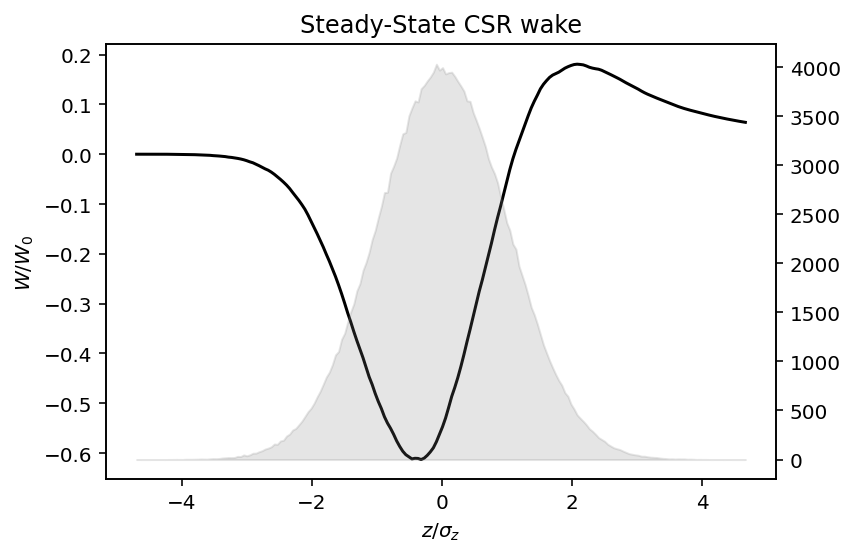

In [9]:
# This is the normalized wake
fig, ax = plt.subplots(figsize=(6,4))
ax.set_ylabel(r'$W/W_0$')
ax.set_xlabel(r'$z/\sigma_z$')
ax.plot(zvec/sigma_z, wake/W0, color='black')

ax2 = ax.twinx()
ax.set_title('Steady-State CSR wake')
ax2.fill_between(zvec/sigma_z, 0, density, alpha=0.2, color='gray')

Text(0.5, 0, 'z (m)')

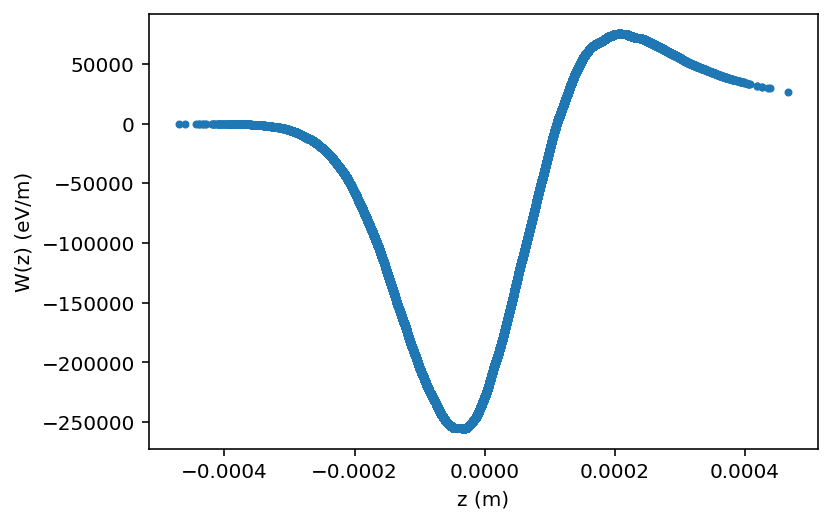

In [10]:
# Interpolate to get the kicks
kicks = np.interp(z, zvec, wake)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(z, kicks, marker='.')
ax.set_ylabel('W(z) (eV/m)')
ax.set_xlabel('z (m)')

# All-in-one function

In [11]:
def csr1d_steady_state_kick_calc(z, weights,
                    *,
                    nz = 100,
                    rho=1,
                    species='electron'):
    
    """

    Steady State CSR 1D model kick calc

    
    Parameters
    ----------
    z : np.array
        Bunch z coordinates in [m]    
        
    weights : np.array
        weight array (positive only) in [C]
        This should sum to the total charge in the bunch        
        
    nz : int
        number of z grid points        
        
    rho : float
        bending radius in [m]        
        
    species : str
        Particle species. Currently required to be 'electron'   
        
    Returns
    -------
    dict with:
    
        denergy_ds : np.array
            energy kick for each particle [eV/m]
            
        wake : np.array
            wake array that kicks were interpolated on
            
        zvec : np.array
            z coordinates for wake array
    
    """
    

    assert species == 'electron', f'TODO: support species {species}'
    
    # Density
    H, edges = np.histogram(z, weights=weights, bins=nz)
    zmin, zmax = edges[0], edges[-1]
    dz = (zmax-zmin)/(nz-1)
    
    zvec = np.linspace(zmin, zmax, nz) # Sloppy with bin centers
    
    Qtot=np.sum(weights)
    density = H/dz/Qtot
    
    # Density derivative
    densityp = np.gradient(density)/dz
    densityp_filtered = savgol_filter( densityp, 13, 2 )
    
    # Green function
    zi = np.arange(0, zmax-zmin, dz)
    factor = -3**(2/3) * Qtot/e_charge * r_e * mec2 * rho**(-2/3)  # factor for denergy/dz [eV/m]
    #factor = -3**(2/3) * Qtot/e_charge * r_e * rho**(-2/3) / gamma  # factor for ddelta/ds [1/m]
    green = factor*np.diff(zi**(2/3))
    
    # Convolve to get wake
    wake = np.convolve(densityp_filtered, green, mode='full')[0:len(zvec)]
    
    # Interpolate to get the kicks
    delta_kick = np.interp(z, zvec, wake)
    
    return {'denergy_ds':delta_kick,
             'zvec':zvec, 'wake':wake
             }


Text(0.5, 0, 'z (m)')

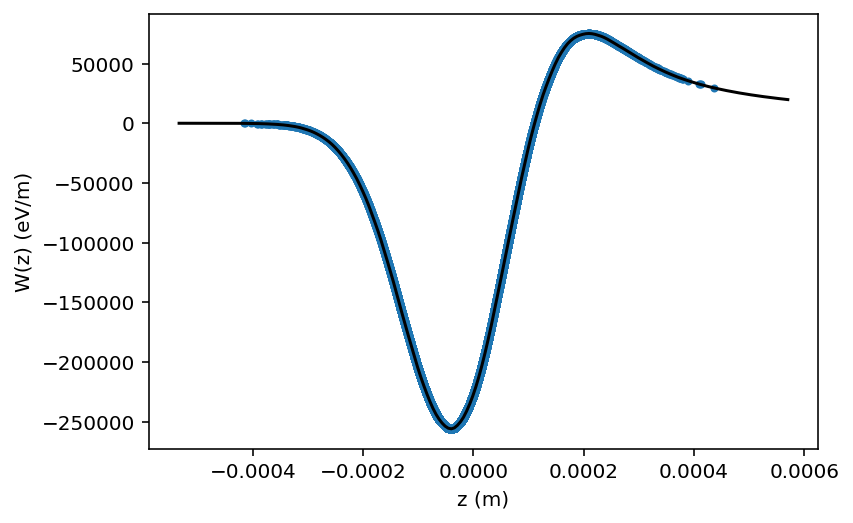

In [12]:
Z = np.random.normal(0, 100e-6 , size=10000000)
W = np.full(len(Z), 1e-9/len(Z))

result = csr1d_steady_state_kick_calc(Z, W, rho=10, nz=200)


fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Z[::100], result['denergy_ds'][::100], marker='.')
ax.plot(result['zvec'], result['wake'], color='black')
ax.set_ylabel('W(z) (eV/m)')
ax.set_xlabel('z (m)')